In [3]:
!pip install hdbscan
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.8 MB/s eta 0:00:0000:01:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-linux_x86_64.whl size=3585085 sha256=0201dc102847e680502b9fc8e54475ff4505750ce79807e6868e03715728f54a
  Stored in directory: /root/.cache/pip/wheels/28/5e/ed/5989da4cc423a222a47cbb4fde5d6c0eff4590d922e45f233c
Successfully built hdbscan


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import hdbscan
import os
import json

import sys
sys.path.append('..')
sys.path.append('../autoencoder')


from fastai import *
from fastai.vision.all import *
from models import SimpleAutoencoder

from src.band_plotters import *
from src.Tiff32Image import Tiff32Image, load_tiff_uint32_image

In [25]:
FINGERPRINT_LENGTH = 4
# fingerprint length for old all_k_paths fingerprint, no need to change for auto-encoded prints!
FINGERPRINT_LENGTH_old = 60

FINGERPRINT_NAME = "12_bands_encoder_L={0}".format(FINGERPRINT_LENGTH)

WIDTH=128
PERPLEXITY = 30
OUTPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"
print(FINGERPRINT_NAME)

12_bands_encoder_L=4


To make a new finerprint all you need to change is the constants above and/or the calc_fingerprint function below.
# All K Branches Histogram Fingerprint
Bin all energy values between -8 and +8 eV for each branch in K space.

## Start with Anupam's list of materials

In [26]:
df_material = pd.read_csv("../fingerprints/template.csv", index_col="ID")
df_material.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,C,D,E,F,radio,f_orb,sg_sto_group,percentage_flat,relative_id,crystal_system
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4963,trigonal
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3279,trigonal
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2,2dm-5155,triclinic
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4342,trigonal
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3574,trigonal


## Fingerprint Functions Here
Fingerprint functions take material ID as only input

In [27]:
def run_trained_model_one_mat(material_id, CNN_model, input_band_image_type, width, data_directory=DATA_DIRECTORY):
        image_filename = data_directory/f"images/energies{input_band_image_type}/{material_id}.tiff"
        
        input_numpy = load_tiff_uint32_image(image_filename).astype(np.float64)
        
        # resize width of tensor
        if width:
            input_numpy = resize(input_numpy, (input_numpy.shape[0], width))
            
        input_tensor = torch.from_numpy(input_numpy)
        input_tensor = input_tensor / (2**16-1)
        input_tensor = input_tensor[None, None, :, :]
        

        input_tensor = input_tensor.float().cpu()
        output_tensor = CNN_model.encode.forward(input_tensor)
        
        # flatten encoded 2d array representation of the band structure as the fingerprint
        return output_tensor.flatten().detach().numpy()
        
# change path to the location of the desired trained model
model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# name of the energy{name} folder which holds the input band tensors
CNN_input_file_index = "_12_nearest_bands"
# load the model that we have already trained on the data
trained_model = load_learner(model_path)

fingerprint = run_trained_model_one_mat("2dm-11", trained_model.model, CNN_input_file_index, WIDTH)
print(fingerprint)

[-0.12674935  0.0699515   0.0310086   0.07706276]


In [28]:
def calc_all_k_branches_histogram_fingerprint(material_id, fingerprint_length=FINGERPRINT_LENGTH_old, e_range=None, normalize=False, shifted=True):
    filename_bands=DATA_DIRECTORY/f"bands/{material_id}.json"
    if not filename_bands.exists():
        print(f"No such file {filename_bands}")
        
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    if shifted:
        energies -= bands_dict["efermi"]

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]

        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range, density=normalize)

        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint

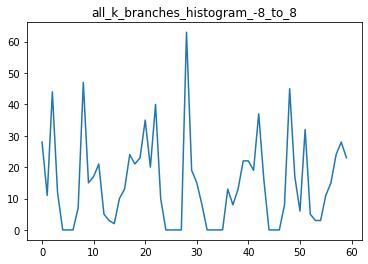

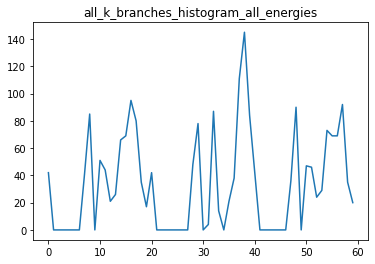

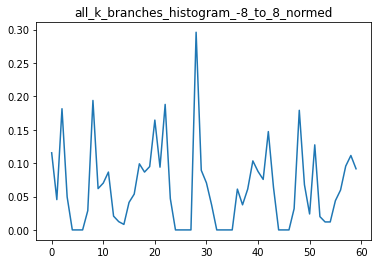

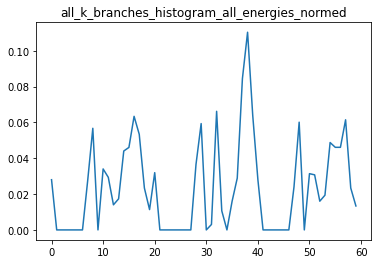

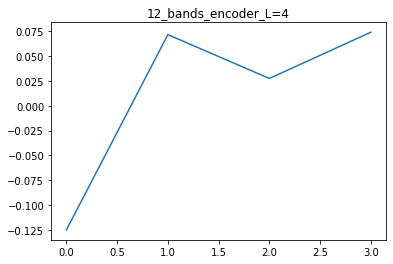

In [29]:
fingerprint_functions = {
    "all_k_branches_histogram_-8_to_8": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=False),
    "all_k_branches_histogram_all_energies": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=False),
    "all_k_branches_histogram_-8_to_8_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=True),
    "all_k_branches_histogram_all_energies_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=True),
    "12_bands_encoder_L={0}".format(FINGERPRINT_LENGTH): lambda x: run_trained_model_one_mat(x, CNN_model=trained_model, input_band_image_type=CNN_input_file_index, width=WIDTH)
}

for fingerprint_name in fingerprint_functions: 
    fp = fingerprint_functions[fingerprint_name]("2dm-1")
    plt.plot(fp)
    plt.title(fingerprint_name)
    plt.show()
    

In [30]:
fingerprint_array = np.zeros([len(df_material), FINGERPRINT_LENGTH])

In [31]:
for i, material_id in enumerate(df_material.index):
    if i % 100 == 0:
        print(i, "/", len(df_material))

    fingerprint_array[i, :] = fingerprint_functions[FINGERPRINT_NAME](material_id)

print(fingerprint_array)

0 / 5270
100 / 5270
200 / 5270
300 / 5270
400 / 5270
500 / 5270
600 / 5270
700 / 5270
800 / 5270
900 / 5270
1000 / 5270
1100 / 5270
1200 / 5270
1300 / 5270
1400 / 5270
1500 / 5270
1600 / 5270
1700 / 5270
1800 / 5270
1900 / 5270
2000 / 5270
2100 / 5270
2200 / 5270
2300 / 5270
2400 / 5270
2500 / 5270
2600 / 5270
2700 / 5270
2800 / 5270
2900 / 5270
3000 / 5270
3100 / 5270
3200 / 5270
3300 / 5270
3400 / 5270
3500 / 5270
3600 / 5270
3700 / 5270
3800 / 5270
3900 / 5270
4000 / 5270
4100 / 5270
4200 / 5270
4300 / 5270
4400 / 5270
4500 / 5270
4600 / 5270
4700 / 5270
4800 / 5270
4900 / 5270
5000 / 5270
5100 / 5270
5200 / 5270
[[-0.12514111  0.07180917  0.02759938  0.07420947]
 [-0.12280439  0.06812406  0.02905612  0.07590233]
 [-0.12139853  0.06846646  0.02821302  0.07517588]
 ...
 [-0.12095675  0.06802337  0.02772982  0.07490434]
 [-0.12159545  0.06935124  0.02725978  0.0734474 ]
 [-0.12162974  0.0692292   0.02743317  0.07361056]]


In [32]:
#check for NaNs 
np.isnan(fingerprint_array).sum()

0

## Create T-SNE Reduced Dimension Fingerprints

In [33]:
tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprint_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5270 samples in 0.004s...
[t-SNE] Computed neighbors for 5270 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5270
[t-SNE] Computed conditional probabilities for sample 2000 / 5270
[t-SNE] Computed conditional probabilities for sample 3000 / 5270
[t-SNE] Computed conditional probabilities for sample 4000 / 5270
[t-SNE] Computed conditional probabilities for sample 5000 / 5270
[t-SNE] Computed conditional probabilities for sample 5270 / 5270
[t-SNE] Mean sigma: 0.000130
[t-SNE] Computed conditional probabilities in 0.321s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 74.2218857, gradient norm = 0.0053730 (50 iterations in 2.395s)
[t-SNE] Iteration 100: error = 70.8128815, gradient norm = 0.0012961 (50 iterations in 2.187s)
[t-SNE] Iteration 150: error = 70.1830978, gradient norm = 0.0005062 (50 iterations in 2.283s)
[t-SNE] Iteration 200: error = 69.9948120, gradient norm = 0.0002176 (50 iterations in 2.191s)
[t-SNE] Iteration 250: error = 69.9278259, gradient norm = 0.0001036 (50 iterations in 2.412s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.927826
[t-SNE] Iteration 300: error = 2.0739036, gradient norm = 0.0017106 (50 iterations in 2.154s)
[t-SNE] Iteration 350: error = 1.5881875, gradient norm = 0.0007443 (50 iterations in 2.302s)
[t-SNE] Iteration 400: error = 1.3762168, gradient norm = 0.0004416 (50 iterations in 2.203s)
[t-SNE] Iteration 450: error = 1.2590390, gradient norm = 0.0002952 (50 iterations in 2.164s)
[t-SNE] Iteration 500: error = 1.1859556, gradient norm = 0.0002130 (50 

## Quick cluster (not saved) and plots to check fingerprint and T-SNE worked

In [34]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=3, p=0.2)
clusterer.fit(fingerprint_array)
labels = clusterer.labels_

Text(0.5, 1.0, 'fingerprint_length=4')

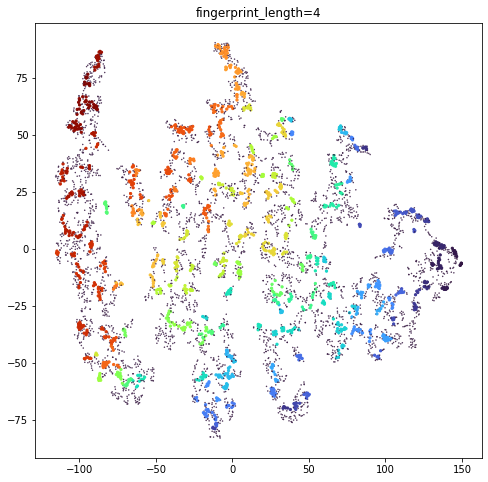

In [35]:
fig, ax  = plt.subplots(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

ax.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")
plt.title("fingerprint_length={0}".format(FINGERPRINT_LENGTH))

## Add fingerprints, T-SNE to dataframe

In [36]:
df = df_material.join(pd.DataFrame(fingerprint_array, index=df_material.index))
df["fx"] = fingerprint_2d[:, 0]
df["fy"] = fingerprint_2d[:, 1]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,sg_sto_group,percentage_flat,relative_id,crystal_system,0,1,2,3,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,NaN,NaN,2dm-4963,trigonal,-0.125141,0.071809,0.027599,0.074209,44.027458,-73.077988
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,NaN,NaN,2dm-3279,trigonal,-0.122804,0.068124,0.029056,0.075902,67.173775,29.810295
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,276.0,24.2,2dm-5155,triclinic,-0.121399,0.068466,0.028213,0.075176,-15.556751,11.918595
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,NaN,NaN,2dm-4342,trigonal,-0.122914,0.068484,0.028327,0.075781,61.176208,22.973383
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,NaN,NaN,2dm-3574,trigonal,-0.123266,0.070354,0.027745,0.074759,31.947668,-52.847237


In [37]:
df.to_csv("../fingerprints/"+OUTPUT_NAME)

# View a predicted band 

array([<AxesSubplot:title={'center':'Input'}>,
       <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object)

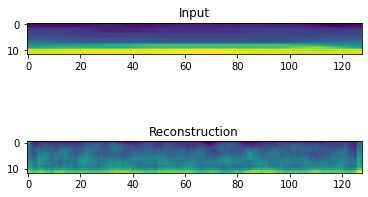

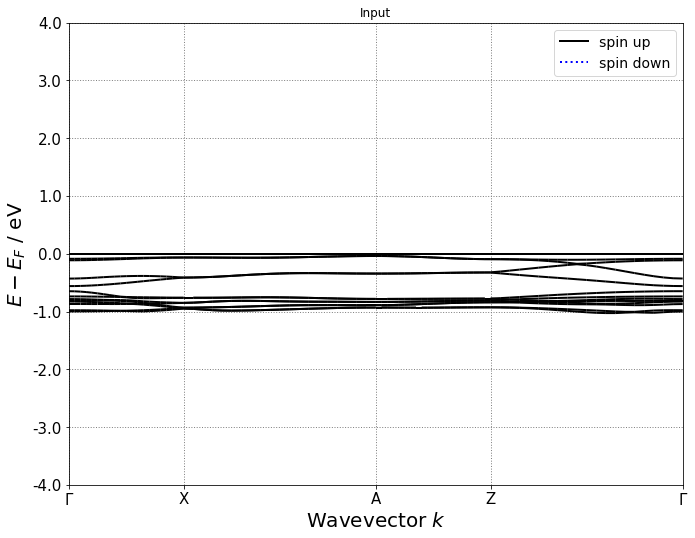

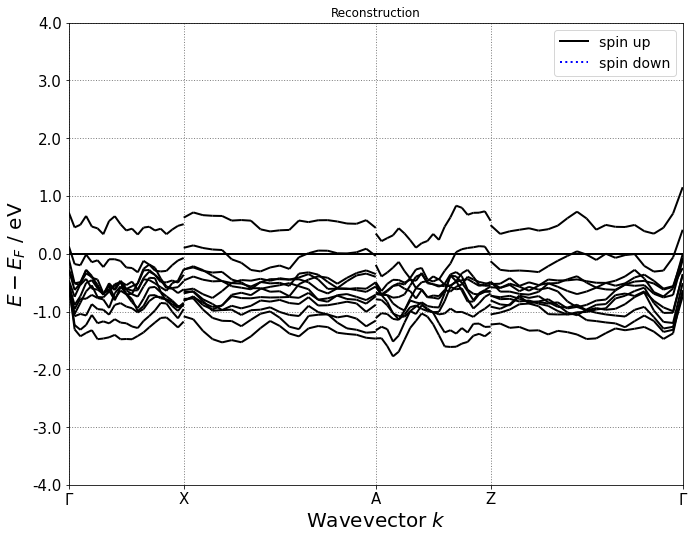

In [38]:

#from models import *

view_prediction("2dm-1979", trained_model.model, -17, 20, width=128)